# 제4 고지 : 신경망 만들기 
## STEP 42 : 선형 회귀

머신러닝은 '데이터' 를  사용하여 문제를 해결하는 것이 본질이다. 이번 단계에서는 머신러닝의 가장 기본이 되는 `선형 회귀(linear regression)` 을 구현하도록 한다.

### 42.1 토이 데이터셋 

<p align='center'>
    <img src='../assets/그림 42-1.png' align='center' width='30%'>
</p>


```python
import numpy as np 
np.random.seed(0) # 시드 고정
x = np.random.rand(100,1)
y = 5 + 2 * x + np.random.rand(100,1) # y에 무작위 노이즈 추가
```

$x$ 와 $y$ 두개의 변수로 구성된 토이 테이터 셋을 생성한다. 이때, $x$,$y$ 는 **선형** 관계 인데, 노이즈 추가로 점들이 퍼져있음을 확인할 수 있다. 

<span style='background-color : #ffdce0'>💡<b> $x$ 로 부터 실수값 $y$ 를 예측하는 것을 회귀(regression) 이라 하며, 회귀 모델 중 예측값이 선형인 것을 선형회귀(linear regression) 이라 한다.</b></span>

### 42.2 선형 회귀 이론
<p align='center'>
    <img src='../assets/그림 42-2.png' align='center' width='30%'>
</p>

$y$ 와 $x$ 가 선형 관계라고 가정하기 때문에 $y=Wx+b$라는 식으로 표현할 수 있다. (여기서 $W$ 는 스칼라로 가정한다.)
위의 그림과 같이 목표는 데이터에 맞는 직선 $y=Wx+b$를 찾는것이다. 그러기 위해서는 **데이터와 예측치의 차이 = 잔차(residual)** 를 최소화 해야 한다. 따라서 다음과 같이 **예측치와 데이터의 오차를 나타내는 지표 = 평균 제곱 오차(mean squared error)**를 정의한다.
$$
L=\frac{1}{N}\sum_{i=1}^N(f(x_i)-y_i)^2 
$$

<span style='background-color : #ffdce0'>💡<b> 모델의 성능이 얼마나 '나쁜가'를 평가하는 함수를 '손실 함수'라 한다. 따라서 선형회귀는 '손실함수로 평균제곱오차를 이용한다' 라고 할 수 있다.</b></span>

### 42.3 선형 회귀 구현

이제 이론을 바탕으로 선형 회귀를 DeZero로 구현해보자.
여기서 주목해야 할것은 다음 두가지이다. 
<p align='center'>
    <img src='../assets/그림 42-4.png' align='center' width='30%'>
</p>

1. **행렬 연산 시 차원을 잘 맞춰야 제대로 계산**이 이뤄진다.
2. b의 shape은 (1,) 이지만 이전에 구현한 **broadcast가 일어나 (100,1)로 변환**되어 계산과 역전파가 잘 이뤄진다.
3. 차원 $D=4$인 100개의 데이터는 **행렬 연산으로 모든 데이터의 예측치**를 구할 수 있다.
4. 매개변수 $W$,$b$ 갱신할때 인스턴스 변수의 data에 대해 계산해야 한다.이때 매개변수 갱신은 단순히 데이터를 갱신할 뿐이므로 계산 그래프를 만들 필요가 없다.


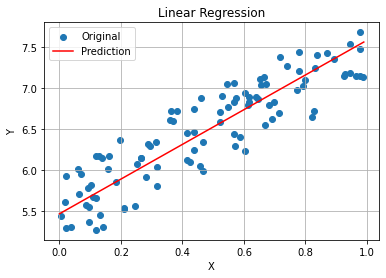

In [8]:
import sys
sys.path.append("..")

import numpy as np 
from dezero import Variable
import dezero.functions as F 

# 토이 데이터셋
np.random.seed(0) # 시드 고정
x = np.random.rand(100,1)
y = 5 + 2 * x + np.random.rand(100,1) # y에 무작위 노이즈 추가

W = Variable(np.zeros((1,1)))
b = Variable(np.zeros(1))

def predict(x):
    y = F.matmul(x,W) + b 
    return y 

def mean_squared_error(x0,x1):
    diff = x0-x1 
    return F.sum(diff**2)/len(diff)

lr = 0.1 
iters = 100 
for i in range(iters):
    y_pred = predict(x)
    loss = mean_squared_error(y,y_pred)
    
    W.cleargrad()
    b.cleargrad()
    loss.backward()
    W.data -=lr*W.grad.data
    b.data -=lr* b.grad.data
    # print(W,b,loss)
    
# 위에서 학습한 가중치 W와 편향 b를 사용하여 시각화
import matplotlib.pyplot as plt
x_plot = np.arange(0, 1, 0.01).reshape((100,1)) 
y_plot = (W.data * x_plot) + b.data 

# 원본 데이터와 학습한 직선을 그래프로 
plt.scatter(x, y, label='Original')  
plt.plot(x_plot, y_plot, label='Prediction', color='red')  
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Linear Regression')
plt.grid(True)
plt.show()


### 42.4 [보충] DeZero의 mean_squared_error 함수
<p align='center'>
    <img src='../assets/그림 42-4.png' align='center' width='30%'>
</p>

```python
def mean_squared_error(x0,x1):
    diff = x0-x1 
    return F.sum(diff**2)/len(diff)

```
앞서 구현한 방식의 문제는 위의 그림과 같이 계산 그래프가 존재하는 동안 이름없는 변수 3개가 메모리에 계속 살아있는다.  
물론 컴퓨터의 메모리가 충분하다면 현재의 구현방식도 문제없지만 `Function` 클래스를 사용하여 개선해보도록 한다.  
(`backward` 구현을 위해서 먼저 수식으로 미분을 계산하여 코드로 작성한다.)

<p align='center'>
    <img src='../assets/그림 42-7.png' align='center' width='30%'>
</p>

```python
class MeanSquaredError(Function):
    def forward(self,x0,x1):
        diff = x0-x1 
        y = (diff**2).sum()/len(diff)
        return y 
        
    def backward(self,gy):
        x0,x1=self.inputs
        diff = x0 - x1
        gx0 = gy * diff * (2. / len(diff))
        gx1 = -gx0 
        return gx0,gx1

def mean_squared_error(x0,x1):
    return MeanSquaredError()(x0,x1)
    def backward(self,gy):
        x0,x1=self.inputs
        diff = x0 - x1
        gx0 = gy * diff * (2. / len(diff))
        gy1 = -gx0 # = gy * -diff * (2./len(diff))
        return gx0,gx1

def mean_squared_error(x0,x1):
    return MeanSquaredError()(x0,x1)

```